In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
names = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(set('.'.join(names)))

stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}

In [5]:
def build_dataset(names):
    block_size = 4
    X, Y = [], []

    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 

In [6]:
import random

random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.1 * len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 20), generator=g)
b1 = torch.randn(200, generator=g)
W1 = torch.randn(80, 200, generator=g)
W2 = torch.randn(200, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
for p in parameters:
    p.requires_grad = True

In [9]:
lr = torch.linspace(-3, 0, 100000)
lr = 10**lr
lr = reversed(lr)

In [10]:
lri = []
lossi = []
stepi=[]

In [11]:

for i in range(100000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(32, 80) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    loss.backward()
    for p in parameters:
        p.data -= lr[i] * p.grad
        p.grad = None
    stepi.append(i)
    lossi.append(loss.log10().item())

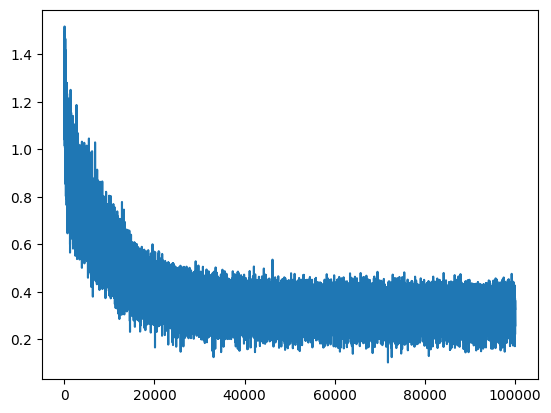

In [12]:
plt.plot(stepi, lossi)

In [13]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 80) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1156, grad_fn=<NllLossBackward0>)

In [14]:
res = []
block_size = 4

for _ in range(10):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, 80) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            res.append(''.join(out))
            break

res

['vioa.',
 'alex.',
 'leob.',
 'valel.',
 'olah.',
 'khamroikha.',
 'crika.',
 'ryia.',
 'mumaenyan.',
 'dadahtan.']

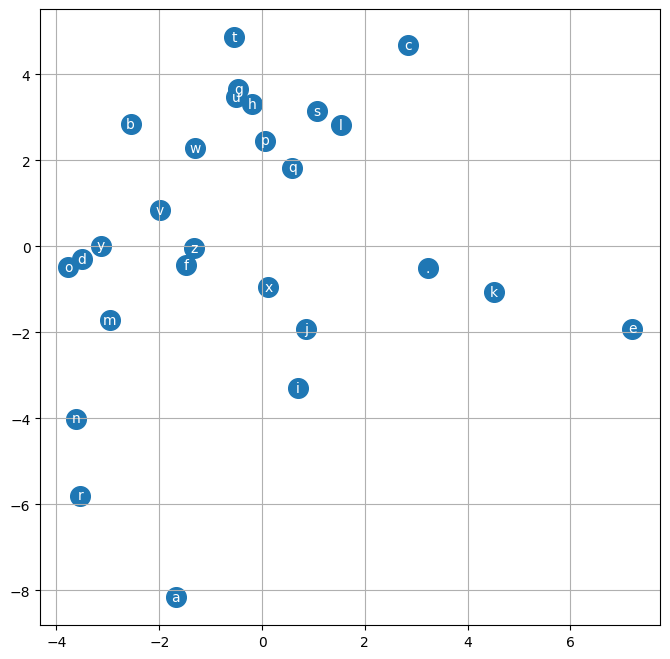

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')